# [2023-11-18] Age factor visualization

In this notebook, we explore how age factors develop across different
initializations of a model and across different models.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as onp
from pathlib import Path
from tqdm.auto import tqdm

from dtd.utils import download_wnb_params

import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from kf_viz import make_tod_series, set_syllable_cluster_ticks, SYLLABLE_PERM_DICT
sns.set_style("darkgrid")

from jaxtyping import Float, Array

/home/libi/anaconda3/envs/kf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

# List run_ids to compare in this notebook
run_ids = [
    'ig6dh2fo',     # `warm-sweep-116`, seed = 1698740237
    # '46grddu7',     # `eternal-sweep-28`, seed = 1698499854 .. parameters not yet updated
    ]

# (Down)load fitted run parameters, retrievable by run_id code
run_params = {
    run_id: download_wnb_params(wnb_entity, wnb_project, run_id)
    for run_id in run_ids
}

print(f'{len(run_params.keys())} runs loaded, with keys \n', run_params[run_ids[0]].keys())

# Load age and name labels, these were re-obtained from the original data
with onp.load('age_name_labels.npz', 'r') as f:
    ages = f['ages']
    names = f['names']

unique_names, i_split = onp.unique(names, return_index=True)
ages_by_fish = onp.split(ages, i_split[1:])
assert len(ages_by_fish) == len(unique_names)
print(f'{len(ages_by_fish)} fish')

1 runs loaded, with keys 
 dict_keys(['G', 'F1', 'F2', 'F3', 'seed', 'avg_train_lps', 'avg_test_ll', 'avg_baseline_test_ll', 'avg_saturated_test_ll', 'avg_lofo_test_ll_1', 'avg_lofo_test_ll_2', 'avg_lofo_test_ll_3', 'run_id'])
82 fish


## Single run examination

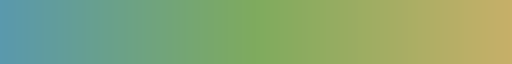

In [3]:
# Setup pretty colors for plotting fish trajectories by lifespan
vmin_age, vmax_age = 90, 350
LIFESPAN_CMAP = sns.color_palette("blend:#5A99AD,#7FAB5E,#C7B069", as_cmap=True)                # Blue to green to yellow
AGE_NORM = mplc.Normalize(vmin=vmin_age, vmax=vmax_age)
REL_AGE_NORM = mplc.Normalize(vmin=0, vmax=1)
# LIFESPAN_CMAP = lambda a: _cmap(_norm(a))

# FOR CREATING COLORBARS
LIFESPAN_MAPPABLE = mpl.cm.ScalarMappable(cmap=LIFESPAN_CMAP, norm=AGE_NORM)

LIFESPAN_CMAP

In [4]:
def split_array_by_fish(arr, ages, axis: int=0) -> onp.ndarray:
    """Split array by fish.
        
        Parameters
            arr: jax.Array, shape (..., D,...)
            ages: list, length N, cumulative D entries
            axis: int, indicating position of length-D axis in `arr`

        Returns
            arr_by_fish: list[jax.Array], length N
        """

    i_split = onp.cumsum([len(ages_i) for ages_i in ages])
    assert i_split[-1] == arr.shape[axis], \
        f'Expected cumulative # of elements in ages to match age mode of array, but got {i_split[-1]} and {arr.shape[axis]}'
    
    return onp.split(arr, i_split[:-1], axis=axis)

In [5]:
from scipy.ndimage import gaussian_filter1d

def multicolored_lineplot(x: Float[Array, "N"],
                          y: Float[Array, "N"],
                          c: Float[Array, "N"],
                          cmap: mplc.Colormap,
                          norm: mplc.Normalize,
                          alpha: float=1):
    """Create LineCollection colored by the value of `c` in the normalized colormap space.

    The `vmin` and `vmax` parameters of `norm` must be set to correspond with
    expected values of `c` for proper color mapping.
    
    Add to plot via `ax.add_collection(lc)`

    Reference:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
    """
    
    # Array of x-y points, shape (N,1,2)
    xy_pts = onp.array([x, y]).T.reshape(-1,1,2)

    # Array of x-y line segments, shape (N-1, 1, 2)
    segments = onp.concatenate([xy_pts[1:], xy_pts[:-1]], axis=1)

    # Creae a LineCollection that uses the specified cmap
    lc = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(c[1:])
    lc.set_alpha(alpha)

    return lc

def plot_age_factor_by_fish_sep(gs, age_component, ages_by_fish, lw=1, color_by='lifespan'):
    """Plot age factors, with each subject seperated onto its own plot."""
    gs_fctr = gs.subgridspec(nrows=len(ages_by_fish), ncols=1, hspace=0.1)

    age_component_by_fish = split_array_by_fish(age_component, ages_by_fish)

    # Share axes across all fish
    xmin = onp.min(list(map(lambda ages: ages[0], ages_by_fish)))
    xmax = onp.max(list(map(lambda ages: ages[-1], ages_by_fish)))
    ymax = onp.minimum(2*onp.quantile(age_component, 0.99), 1)
    # y_max = 1

    # Sort subjects from shortest-living to longest living
    axs = []
    i_sort = onp.argsort(list(map(lambda ages: ages[-1], ages_by_fish)))
    for i_ax, i in enumerate(i_sort):
        _ages = ages_by_fish[i]
        _component = age_component_by_fish[i]

        ax = plt.gcf().add_subplot(gs_fctr[i_ax,:])

        if color_by == 'rel_age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(0, 1)
            ax.margins(x=1.1)
        elif color_by == 'age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(xmin, xmax)
        elif color_by == 'lifespan':   # color by lifespan
            c = LIFESPAN_CMAP(AGE_NORM(_ages[-1]))
            ax.plot(_ages, _component, color=c, lw=lw)
            ax.set_xlim(xmin, xmax)
        else:
            raise ValueError("Expected `color_by`=\{'rel_age', 'age', 'lifespan'\}," + f" but got '{color_by}'.")
            
        ax.set_ylim(0, ymax)

        # Only label ticks on last row; deemphasize axes of intermediate rows
        if i_ax < len(ages_by_fish) - 1:
            ax.tick_params(length=1, labelleft=False, labelbottom=False)
            ax.spines['bottom'].set_color('0.4')
        else:
            ax.tick_params(length=1, labelleft=False, labelsize='x-small' )
        
        sns.despine(ax=ax)
        axs.append(ax)
    return axs

def plot_age_factor_by_fish_overlaid(gs, age_component, ages_by_fish, lw=1, color_by='lifespan', alpha=1, sigma=0):
    """Plot age factors, with each subject seperated onto its own plot."""

    age_component_by_fish = split_array_by_fish(age_component, ages_by_fish)

    # Share axes across all fish
    xmin = onp.min(list(map(lambda ages: ages[0], ages_by_fish)))
    xmax = onp.max(list(map(lambda ages: ages[-1], ages_by_fish)))
    ymax = onp.minimum(2*onp.quantile(age_component, 0.99), 1)
    # y_max = 1

    # Sort subjects from shortest-living to longest living
    ax = plt.gcf().add_subplot(gs)
    i_sort = onp.argsort(list(map(lambda ages: ages[-1], ages_by_fish)))
    for i_ax, i in enumerate(i_sort):
        _ages = ages_by_fish[i]
        
        _component = age_component_by_fish[i]
        
        if sigma > 0:
            _component = gaussian_filter1d(age_component_by_fish[i], sigma, axis=0)
        

        if color_by == 'rel_age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM, alpha=alpha)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(0, 1)
            ax.margins(x=1.1)
        elif color_by == 'age':
            lc = multicolored_lineplot(_ages, _component, onp.asarray(_ages)/_ages[-1], LIFESPAN_CMAP, REL_AGE_NORM, alpha=alpha)
            lc.set_linewidth(lw)
            ax.add_collection(lc)
            ax.set_xlim(xmin, xmax)
        elif color_by == 'lifespan':   # color by lifespan
            c = LIFESPAN_CMAP(AGE_NORM(_ages[-1]))
            ax.plot(_ages, _component, color=c, lw=lw, alpha=alpha)
            ax.set_xlim(xmin, xmax)
        else:
            raise ValueError("Expected `color_by`=\{'rel_age', 'age', 'lifespan'\}," + f" but got '{color_by}'.")
        
    ax.set_ylim(0, ymax)

    # Only label ticks on last row; deemphasize axes of intermediate rows
    ax.tick_params(length=1, labelleft=False, labelbottom=False)
    ax.spines['bottom'].set_color('0.4')
        
    sns.despine(ax=ax)
    return ax

def plot_normd_age_factor_and_mat(gs, core, age_fctr, tod_fctr, syllable_fctr, a, ages):
    # Plot age factor
    # ax_fctrs = plot_age_factor_by_fish_sep(gs[0,:], age_fctr[:,a], ages, lw=0.5, color_by='age')
    # ax_fctrs[-1].set_xlabel('age [days]', fontsize='x-small')
    # ax_fctrs[0].set_title(f'a = {a}')
    
    ax_fctrs = plot_age_factor_by_fish_overlaid(gs[0,:], age_fctr[:,a], ages, lw=0.5, color_by='age', alpha=0.4, sigma=1.5)
    ax_fctrs.set_xlabel('age [days]', fontsize='x-small')
    ax_fctrs.set_title(f'a = {a}')

    # Plot the circadian-topic basis matrix that it interacts with
    ax_elem = plt.gcf().add_subplot(gs[1,1])
    mat_a = onp.einsum('tb,bc,cv->tv', tod_fctr, core[a], syllable_fctr)
    
    im = ax_elem.imshow(mat_a.T, interpolation='none', aspect='auto',
                        cmap='mako', norm=mplc.LogNorm(vmin=1e-2, vmax=1))

    t_dts = make_tod_series('4H')
    t_locs = onp.concatenate([onp.linspace(0, len(tod_fctr), num=len(t_dts), endpoint=False), [len(tod_fctr)]])
    t_labels = list(map(lambda dt: dt.strftime('%H'), t_dts)) + ['24']
    
    ax_elem.set_xticks(t_locs)
    ax_elem.set_xticklabels(t_labels, fontsize='xx-small')

    ax_elem.set_xlabel('time-of-day [hr]', fontsize='x-small')
    
    ax_elem.grid(visible=False, axis='both')
    return (ax_fctrs, ax_elem), im

### Interpretation of age factors

Our DTD model is defined as
$$
\mathcal{Y}_{d,t,v} \sim \textrm{Multinomial}(N, \mathcal{X}_{d,t,v}),
$$
for observation $\mathcal{Y}_{d,t,v}$ on day $t$, timebin $t$ and vocabulary $v$,
and mean rate $\mathcal{X}_{d,t,v}$ and total counts (per event) $N$.
Recall that the mean rate is given by
$$
\mathcal{X}_{d,t,:} = \sum_{c=1}^{K_V} \left(
    \left(\sum_{a=1}^{K_D} \sum_{b=1}^{K_T} \mathcal{G}_{a,b,c} \psi_{d,a} \phi_{t,b}\right)
    \theta_{:,c} \right) \in \Delta_V,
$$
where we have core tensor and factors
$$
\begin{align*}
    \textrm{core tensor: }&\quad\mathcal{G}_{a,b,:} &\in \Delta_{K_V}, &&\quad \forall a=\{1,\ldots,K_D\}, t=\{1,\ldots,K_T\} \\
    \textrm{age factor: }&\quad\psi_{d,:} &\in \Delta_{K_D}, &&\quad \forall d=\{1,\ldots, D\} \\
    \textrm{circadian bases: }&\quad\phi_{t,:} &\in \Delta_{K_T}, &&\quad \forall t=\{1,\ldots, T\} \\
    \textrm{behavioral topics: }&\quad\theta_{:,c} &\in \Delta_{V}, &&\quad \forall c=\{1,\ldots, K_V\}.
\end{align*}

The age factors $\psi_d \in \Delta_{K_D}$ contribute to the mean rate by acting
on a syllable-day matrix,
$$
X_{d} = \sum_{a=1}^{K_D} \psi_{d,a} \Mu_a = \sum_{a=1}^{K_D} \psi_{d,a} \left(\sum_{b=1}^{K_T} \sum_{c=1}^{K_C} G_{a,b,c} \phi_{t,b} \theta_{c,v}\right).
$$
These matrices, $\Mu_a \in \mathbb{R}^{T\times V}$, which could be thought of as
"behavioral chapters," describe steroetypic ways that behavioral syllables are
used throughout a day, and the corresponding age factor describes how this
"chapter" is used throughout life.

In [6]:
params = run_params['ig6dh2fo']
G, F1, F2, F3 = params['G'], params['F1'], params['F2'], params['F3']

K1, K2, K3 = G.shape

 50%|█████     | 1/2 [00:00<00:00,  2.74it/s]

100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Text(0.5, 0.98, 'top 2 age factors')

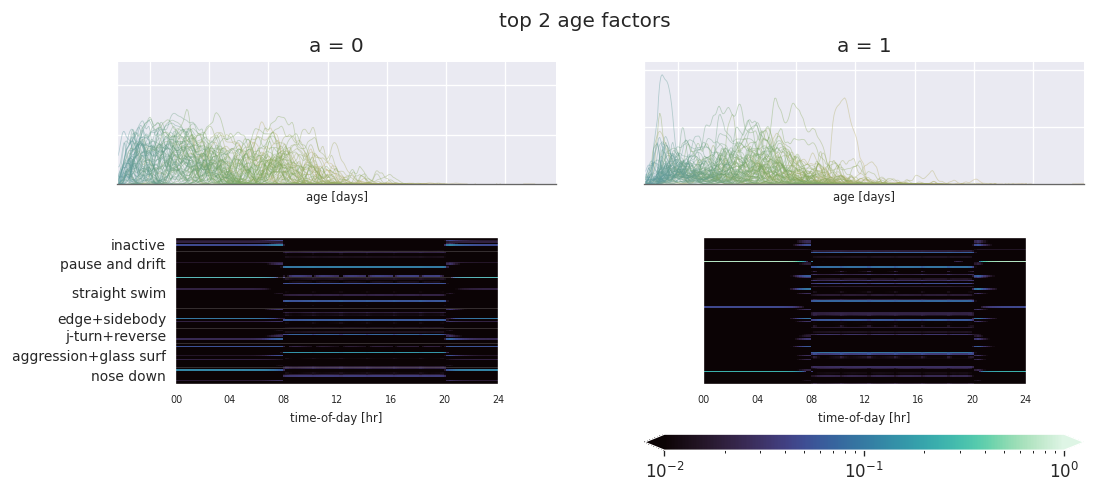

In [7]:
max_factors = 2 # K1
ncols = 2
nrows = max_factors // ncols + ((max_factors % ncols) > 0)

fig = plt.figure(figsize=(ncols * 5.2, nrows*4.2), dpi=120)
gs = fig.add_gridspec(nrows=nrows+1, ncols=ncols, hspace=0.3,
                      height_ratios=[1,]*nrows + [0.05,])

for a in tqdm(range(max_factors)):
    if a >= nrows * ncols: break

    gs_a = gs[a//ncols, a%ncols].subgridspec(nrows=2, ncols=3,
                                             height_ratios=[1, 1.2],
                                             width_ratios=[0.1, 1.0, 0.1],
                                             hspace=0.4)

    (_, ax_elem), im = plot_normd_age_factor_and_mat(gs_a, G, F1, F2, F3, a, ages_by_fish)
    if a % ncols == 0:
        set_syllable_cluster_ticks(ax_elem, axis='y')
    else:
        ax_elem.tick_params(axis='y', labelleft=False)

try:
    cax = fig.add_subplot(gs[-1,1:-1])
except:
    cax = fig.add_subplot(gs[-1,1])
plt.colorbar(im, cax=cax, orientation='horizontal', extend='both')
fig.suptitle(f'top {max_factors} age factors')

## Identifying "significant" factors

### Principal age factors, by log-likelihood variance explained

We looked at the contribution of each age factor to the explained variance.
We do this by holding one factor out, and evaluating the model log-likelihood
with just the remaining factors. The lower the resulting log-likelihood, the more
that the factor (which was withheld) contributed to the variance and therefore
the more significant it is.

Factors that have a _negative_ fraction difference relative to the baseline model
can be viewed as "critically" important (because the model in fact performed
worse than just taking the average empirical probability). Fraction differences
that are positive but close to 0 fracion difference can also be viewed as significant.

However, we find that the age factors, while they have the same distinctive
logarithmic and diminishing contribution to the explained variance as the other
factors, do not have a very distinct subset of important factors.

**!! cross-validation by groups will be likely make a significant contribution here,
in terms of finding age factors that importantly generalize across the population !!**

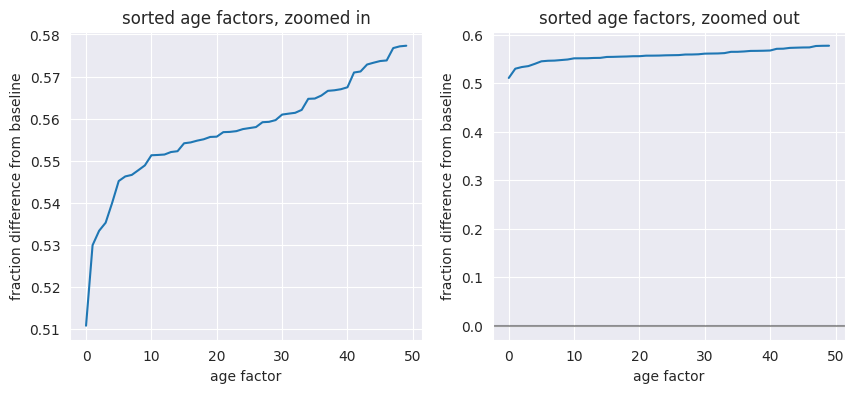

In [8]:
frac_diff = (params['avg_baseline_test_ll'] - params['avg_lofo_test_ll_1']) / params['avg_baseline_test_ll']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axs[0].plot(frac_diff)
axs[0].set_title('sorted age factors, zoomed in')

axs[1].plot(frac_diff)
axs[1].axhline(0, alpha=0.4, color='k')
axs[1].set_title('sorted age factors, zoomed out')

for ax in axs:
    ax.set_xlabel('age factor')
    ax.set_ylabel('fraction difference from baseline')

### Linear correlation with age

Alternatively, we can claculate how each age factor correlates with (relative) age.
We imagine that we will find factors that consistently decrease or increase with age,
and factors that differ in their correlation between short- and long-lived fish

In [9]:
rel_ages = [onp.array(_ages)/_ages[-1] for _ages in ages_by_fish]
lifespans = [_ages[-1] for _ages in ages_by_fish]

n_fish = len(rel_ages)

# Calculate correlation with linear increase in age, of each age factor for each fish
linear_corrs = onp.zeros((K1, n_fish))
for a in range(K1):
    _age_fctr_by_fish = split_array_by_fish(F1[:,a], rel_ages)
    for i in range(n_fish):
        # Construct linear reference
        _refr = onp.linspace(rel_ages[i][0], rel_ages[i][-1], num=len(rel_ages[i]))

        # Calculate correlation betwen age factor and reference line
        linear_corrs[a,i] = onp.corrcoef(_age_fctr_by_fish[i], _refr)[0,1]

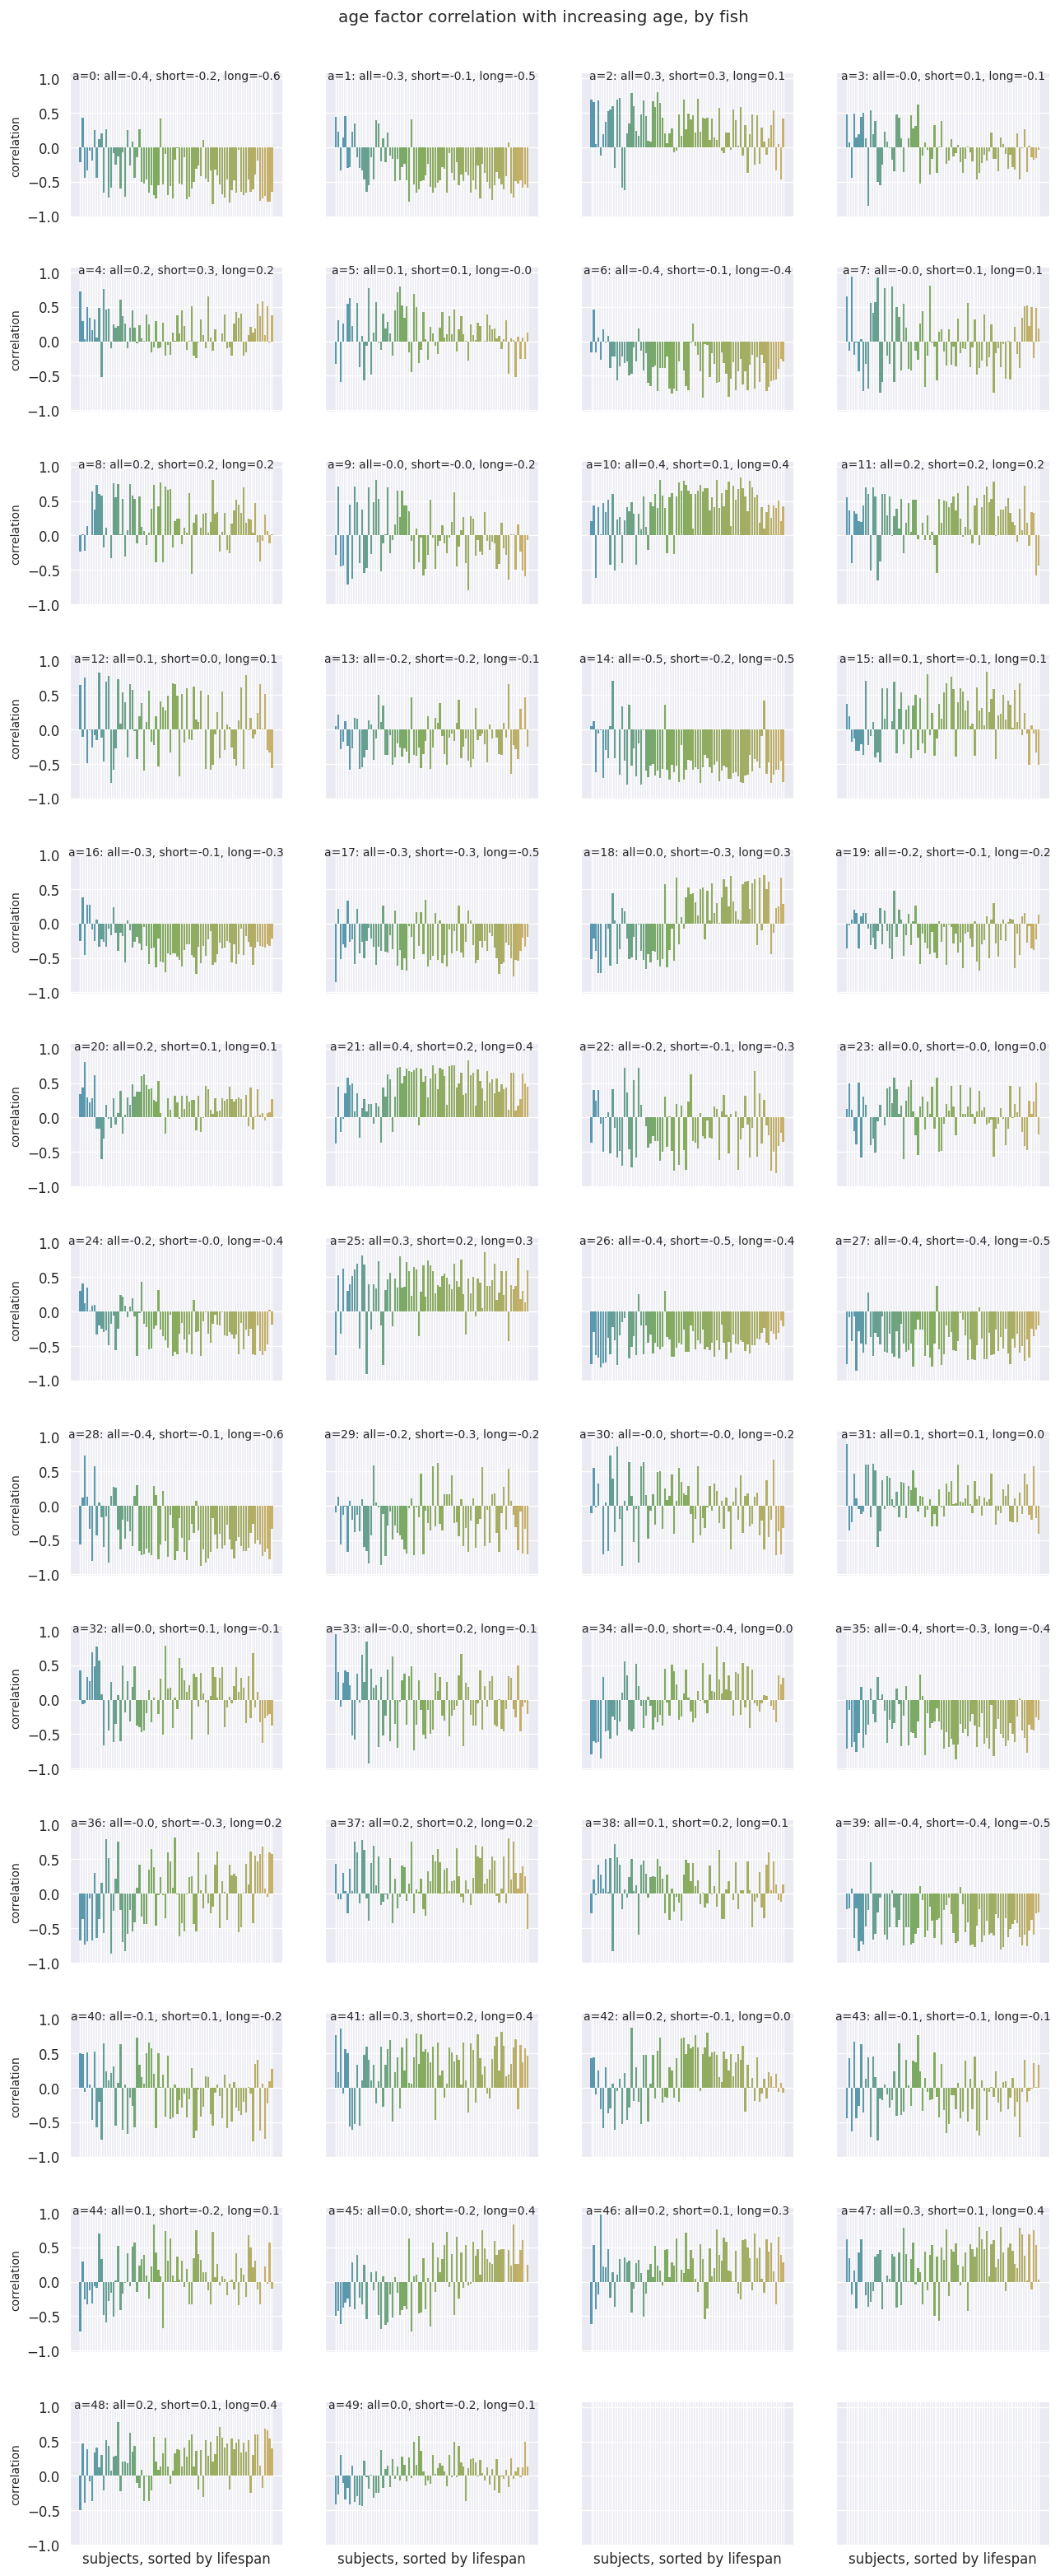

In [10]:
# Plot subjects sorted by lifespan
i_sorted_by_lifespan = onp.argsort(lifespans)
linear_corrs_by_lifespan = linear_corrs[:, i_sorted_by_lifespan]
facecolors_by_lifespan = [LIFESPAN_CMAP(AGE_NORM(lifespans[i])) for i in i_sorted_by_lifespan]

# Plot correlation/anticorrelation with a linear increasing ramp
ncols = 4
nrows = K1 // ncols + ((K1 % ncols) > 0)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        sharex='all', sharey='all',
                        gridspec_kw={'hspace': 0.35, 'wspace':0.2},
                        figsize=(ncols*3.2, nrows*2.5), dpi=120)

for ax, a in zip(axs.ravel(), range(K1)):
    _corrs = linear_corrs_by_lifespan[a]

    
    ax.bar(onp.arange(n_fish), _corrs, color=facecolors_by_lifespan, ec='none')
    ax.set_title(f'a={a}: all={_corrs.mean():.1f}, short={_corrs[:15].mean():.1f}, long={_corrs[-15:].mean():.1f}', fontsize='small', y=0.9)
    ax.set_xticks(onp.arange(n_fish))

for ax in axs[-1]:
    ax.tick_params(labelbottom=False)
    ax.set_xlabel('subjects, sorted by lifespan')
for ax in axs[:,0]:
    ax.set_ylabel('correlation', fontsize='small')

fig.suptitle('age factor correlation with increasing age, by fish', y=0.9)
sns.despine()

Below, we visualize the same plot as above, but with each subplot as its own
boxplot. The boxplot more succinctly captures the distribution of linear correlations
across the population, although it ignores possible clusterings by lifespan group
(although we do not obviously see this in the explode plots baove).

There is no obvious correlation between a factor's contribution to variance explained
and linear correlation. Then again, this is difficult to interpret because all of 
the factor's contribute roughly the same to the variance.

In [11]:
# plt.figure(figsize=(16,6))
# sns.boxplot(x=_tmp.ravel(), y=linear_corrs_by_lifespan.ravel())
# plt.gca().axhline(0, color='k')

## UMAP of age factors

In [14]:
# Sweep over umap N_NEIGHBORS and MIN_DIST parameters
import umap
import itertools

# n_neighbors_frac_list = [0.0025, 0.005, 0.01, 0.05, 0.1,]
n_neighbors_list = [20, 25, 30, 35, 40, 50]
min_dist_list = [0.1, 0.2, 0.3,] # range between 0 and 1

# ---------------------------------------------------------------------------
D1, K1 = F1.shape
n_umap_components = 2

# n_neighbors_frac_list = onp.asarray(n_neighbors_frac_list)
n_neighbors_list = onp.asarray(n_neighbors_list)
min_dist_list = onp.asarray(min_dist_list)

# Convert n_neighbors_frac_list to absolute number of neighbors
# n_neighbors_list = onp.asarray(D1 * n_neighbors_frac_list, dtype=int)

# Plot variable with fewer terms along the columns
row_arr, col_arr, fit_fn = \
    (n_neighbors_list, min_dist_list, lambda r, c: umap.UMAP(n_neighbors=r, min_dist=c, n_components=n_umap_components)) \
    if len(n_neighbors_list) > len(min_dist_list) \
    else  (min_dist_list, n_neighbors_list, lambda r, c: umap.UMAP(n_neighbors=c, min_dist=r, n_components=n_umap_components)) 

umap_ndarrays = onp.zeros((len(row_arr), len(col_arr), D1, n_umap_components))
for i_row, i_col in tqdm(itertools.product(range(len(row_arr)), range(len(col_arr))), total=len(row_arr)*len(col_arr)):
    row_var, col_var = row_arr[i_row], col_arr[i_col]
    fit = fit_fn(row_var, col_var)
    umap_ndarrays[i_row, i_col] = fit.fit_transform(F1)

100%|██████████| 20/20 [03:03<00:00,  9.18s/it]


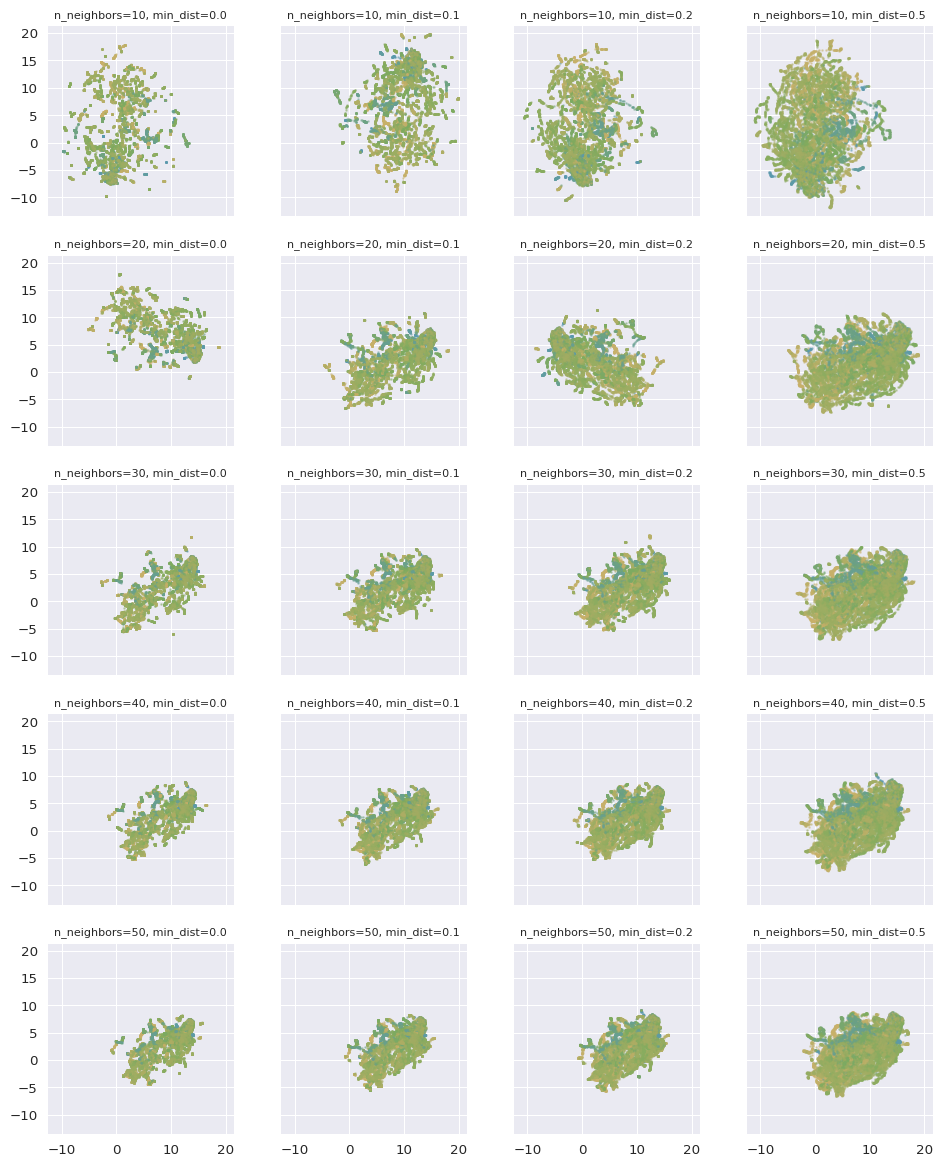

In [15]:
fig, axs = plt.subplots(len(row_arr), len(col_arr), sharex=True, sharey=True,
                        figsize=(3*len(col_arr),3*len(row_arr)), dpi=96)

row_name, col_name = ('n_neighbors', 'min_dist') \
                     if len(n_neighbors_list) > len(min_dist_list) \
                     else ('min_dist', 'n_neighbors')
for (i_row, i_col), ax in onp.ndenumerate(axs):
    u = umap_ndarrays[i_row, i_col]
    u_by_fish = split_array_by_fish(u, ages_by_fish)

    for _u, _ages, in zip(u_by_fish, ages_by_fish):
        # Color each fish's trajectory by their final lifespan
        ax.scatter(_u[:,0], _u[:,1], s=4, alpha=0.4, marker='.', color=LIFESPAN_CMAP(AGE_NORM(_ages[-1])))

        ax.set_aspect('equal')

        ax.set_title(f'{row_name}={row_arr[i_row]}, {col_name}={col_arr[i_col]}', fontsize='small')

In [16]:
import umap

# Use all components! Since they're all equally important!
age_fctr_components = F1

# n_neighbors = int(len(age_fctr_components) * 0.1) / 2
n_neighbors = 72
min_dist = 0.5
n_umap_components = 3
metric = 'euclidean'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_umap_components,
        metric=metric
    )
u = fit.fit_transform(age_fctr_components)

print('Fitted!')

Fitted!


In [ ]:
u_by_fish = split_array_by_fish(u, ages_by_fish)

fig = plt.figure(figsize=(9,9), dpi=120)
for _u, _ages, in zip(u_by_fish, ages_by_fish):
    m = '.'

    # Color continuously by relative age, good to see change in variance with age
    # rel_ages = onp.array(_ages) / _ages[-1]
    # plt.scatter(_u[:,0], _u[:,1], s=6, c=rel_ages, marker=m, cmap=LIFESPAN_CMAP, norm=REL_AGE_NORM)
    
    # Color one fish's trajectory by their lifespan
    plt.scatter(_u[:,0], _u[:,1], s=6, marker=m, color=LIFESPAN_CMAP(AGE_NORM(_ages[-1])))

plt.gca().set_aspect('equal')
plt.title(f'input_dim={age_fctr_components.shape[-1]}, n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}')
plt.colorbar(LIFESPAN_MAPPABLE, ax=plt.gca(), label='lifespan', shrink=0.6, extend='both')
sns.despine()

In [ ]:
fig = plt.figure(figsize=(9,9), dpi=120)
ax = fig.add_subplot(projection='3d')
for _u, _ages, in zip(u_by_fish, ages_by_fish):
    m = '.'
    # onp.sort(lifespans)
    # if _ages[-1] < 200: m = 'X'
    # elif _ages[-1] >= 200: m = '*'
    # else: m = 'o'

    rel_ages = onp.array(_ages) / _ages[-1]
    ax.scatter(_u[:,0], _u[:,1], _u[:,2], s=6, c=rel_ages, marker=m, cmap=LIFESPAN_CMAP, norm=REL_AGE_NORM)

ax.view_init(elev=15)
plt.gca().set_aspect('equal')
plt.title(f'input_dim={age_fctr_components.shape[-1]}, n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}')
sns.despine()

IndexError: index 2 is out of bounds for axis 1 with size 2

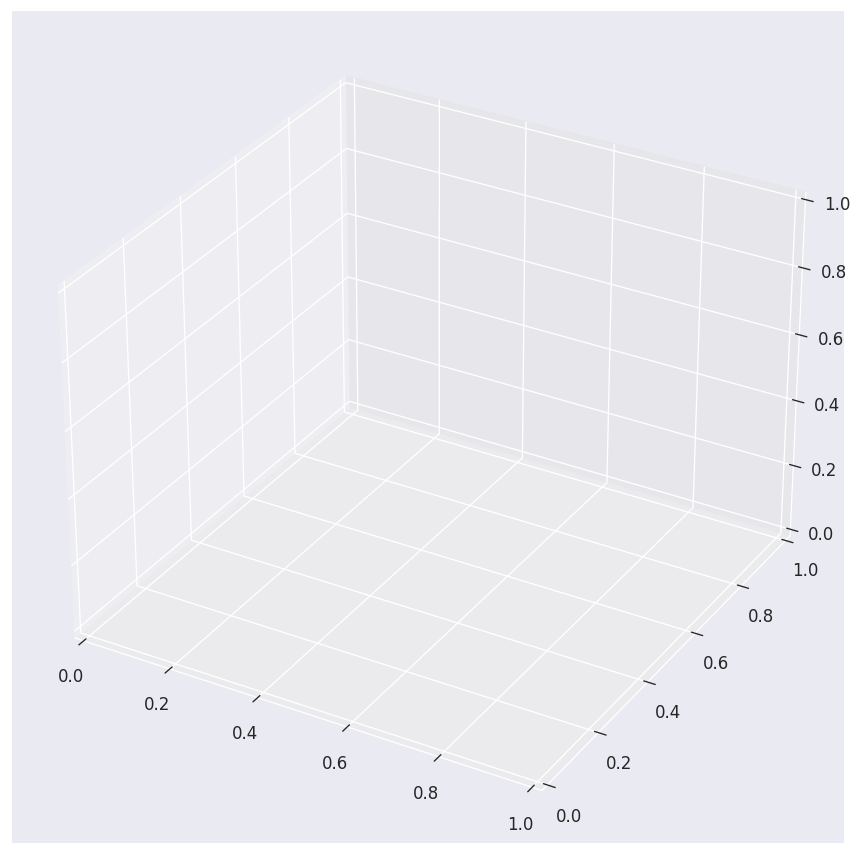

In [17]:
fig = plt.figure(figsize=(9,9), dpi=120)
ax = fig.add_subplot(projection='3d')
for _u, _ages, in zip(u_by_fish, ages_by_fish):
    m = '.'
    # onp.sort(lifespans)
    # if _ages[-1] < 200: m = 'X'
    # elif _ages[-1] >= 200: m = '*'
    # else: m = 'o'

    # Color by final lifespan
    ax.scatter(_u[:,0], _u[:,1], _u[:,2], s=6, marker=m, color=LIFESPAN_CMAP(AGE_NORM(_ages[-1])))

ax.view_init(elev=15, azim=150)
plt.gca().set_aspect('equal')
plt.title(f'input_dim={age_fctr_components.shape[-1]}, n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}')
sns.despine()

In [ ]:
vmin_age, vmax_age = 50, 320
AGE_NORM = mpl.colors.Normalize(vmin=vmin_age, vmax=vmax_age)
LIFESPAN_CMAP_WHITE = sns.color_palette("blend:#FFFFFF,#5A99AD,#7FAB5E,#C7B069", as_cmap=True)                # Blue to green to yellow

In [ ]:
ncols = 6
nrows = 14
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', sharey='all',
                        subplot_kw={'aspect': 'equal'},
                        figsize=(16,36), dpi=120)

for i_ax, ax in enumerate(axs.ravel()):
    if i_ax >= len(i_sorted_by_lifespan):
        break
    # Plot all points as background
    ax.scatter(u[:,0], u[:,1], c='0.4', alpha=0.3, marker='.', s=4, linewidths=0.5)

    i_fish = i_sorted_by_lifespan[i_ax]
    _u = gaussian_filter1d(u_by_fish[i_fish], sigma=0.5)
    lc = multicolored_lineplot(_u[:,0], _u[:,1], ages_by_fish[i_fish], LIFESPAN_CMAP_WHITE, AGE_NORM)
    lc.set_linewidth(1)
    ax.add_collection(lc)

    ax.set_title(f'{unique_names[i_fish]}, {ages_by_fish[i_fish][-1]} days', fontsize='small')

sns.despine()

In [ ]:
from sklearn.decomposition import PCA

transformed_F1 = PCA(n_components=2).fit_transform(F1)
transformed_F1 = split_array_by_fish(transformed_F1, ages_by_fish)

fig = plt.figure(figsize=(9,9), dpi=120)
for _u, _ages, in zip(transformed_F1, ages_by_fish):
    m ='.'

    rel_ages = onp.array(_ages) / _ages[-1]
    plt.scatter(_u[:,0], _u[:,1], s=6, c=rel_ages, marker=m, cmap=LIFESPAN_CMAP, norm=REL_AGE_NORM)

plt.gca().set_aspect('equal')
plt.title(f'pca')
sns.despine()
